In [1]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
SIZE = 256
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip()
])

transform_resize = transforms.Compose([
    transforms.Resize((SIZE, SIZE))
])

In [6]:
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from PIL import Image

class DualImageDataset(torch.utils.data.Dataset):
  def __init__(self, transform, dataset=None, paths=None):
      self.dataset = dataset
      self.paths = paths
      self.transform = transform

  def __len__(self):
      length = 0
      if self.dataset:
        length = len(self.dataset)
      if self.paths:
        length = len(self.paths)
      return length
  def __getitem__(self, idx):
      if self.dataset:
        image, _ = self.dataset[idx]
      if self.paths:
        image = Image.open(self.paths[idx])

      # Resize image
      image = self.transform(image).convert("RGB")

      # Convert to numpy array and LAB color space
      image = np.array(image)
      img_lab = rgb2lab(image).astype("float32") # Converting RGB to L*a*b
      img_lab = transforms.ToTensor()(img_lab)
      L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
      AB = img_lab[[1, 2], ...] / 110. # Between -1 and 1

      return L, AB

In [7]:
import glob
paths = glob.glob(coco_path + "/*.jpg")

np.random.seed(130)

paths_subset = np.random.choice(paths, 10_000, replace=False)
rand_idxs = np.random.permutation(10_000) #Random 10,000 images from COCO dataset
train_idxs = rand_idxs[:8000]
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs].tolist()
val_paths = paths_subset[val_idxs].tolist()

train_dataset = DualImageDataset(transform, dataset=None, paths=train_paths)
val_dataset = DualImageDataset(transform_resize, dataset=None, paths=val_paths)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEncoderDecoder(nn.Module):
    def __init__(self):
        super(CNNEncoderDecoder, self).__init__()

        # Encoding layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Assuming 1 channel for input
        self.leaky_relu = nn.LeakyReLU(0.01)  # Define LeakyReLU once and reuse
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Decoding layers
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        # Final layers after concatenation
        self.conv8 = nn.Conv2d(65, 64, kernel_size=3, stride=1, padding=1)  # Concatenates with initial input
        self.bn6 = nn.BatchNorm2d(64)

        self.conv9 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoding path
        out1 = self.leaky_relu(self.conv1(x))
        out2 = self.leaky_relu(self.conv2(out1))
        out2 = self.bn1(out2)
        out2 = self.pool1(out2)  # Max pooling layer after second conv block

        out3 = self.leaky_relu(self.conv3(out2))
        out3 = self.bn2(out3)
        out3 = self.pool2(out3)  # Max pooling layer after third conv block

        out4 = self.leaky_relu(self.conv4(out3))
        out4 = self.bn3(out4)

        out5 = self.leaky_relu(self.conv5(out4))
        out5 = self.bn4(out5)

        # Decoding path
        up1 = self.upsample1(out5)
        out6 = self.leaky_relu(self.conv6(up1))
        out6 = self.bn5(out6)

        up2 = self.upsample2(out6)
        out7 = self.leaky_relu(self.conv7(up2))

        # Concatenate with input and apply final layers
        concat = torch.cat([out7, x], dim=1)  # Concatenates along the channel dimension
        out8 = self.leaky_relu(self.conv8(concat))
        out8 = self.bn6(out8)

        out9 = self.leaky_relu(self.conv9(out8))
        out10 = torch.tanh(self.conv10(out9))

        return out10

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

def train_model(model, train_dataloader, num_epochs, learning_rate=0.001):
    # Define loss function and optimizer
    criterion = nn.L1Loss()  # L1 Error Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Check if a GPU is available and if so, move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for i, (grayscale_image, original_image) in enumerate(tqdm(train_dataloader)):
            # Move images to the same device as the model
            original_image, grayscale_image = original_image.to(device), grayscale_image.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(grayscale_image)
            # outputs = torch.cat([outputs, grayscale_image], dim=1)
            loss = criterion(outputs, original_image)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        # Print epoch loss
        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    print("Training complete.")

In [11]:
CNNmodel = CNNEncoderDecoder()
train_model(CNNmodel, train_dataloader, num_epochs=100, learning_rate=0.001)

100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Epoch [1/100], Average Loss: 0.0853


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [2/100], Average Loss: 0.0826


100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch [3/100], Average Loss: 0.0824


100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch [4/100], Average Loss: 0.0823


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [5/100], Average Loss: 0.0821


100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


Epoch [6/100], Average Loss: 0.0820


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [7/100], Average Loss: 0.0819


100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch [8/100], Average Loss: 0.0818


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [9/100], Average Loss: 0.0816


100%|██████████| 250/250 [00:57<00:00,  4.31it/s]


Epoch [10/100], Average Loss: 0.0817


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


Epoch [11/100], Average Loss: 0.0815


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [12/100], Average Loss: 0.0814


100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


Epoch [13/100], Average Loss: 0.0813


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [14/100], Average Loss: 0.0813


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Epoch [15/100], Average Loss: 0.0812


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Epoch [16/100], Average Loss: 0.0812


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Epoch [17/100], Average Loss: 0.0811


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


Epoch [18/100], Average Loss: 0.0811


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Epoch [19/100], Average Loss: 0.0810


100%|██████████| 250/250 [01:01<00:00,  4.09it/s]


Epoch [20/100], Average Loss: 0.0809


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [21/100], Average Loss: 0.0807


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [22/100], Average Loss: 0.0807


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [23/100], Average Loss: 0.0807


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [24/100], Average Loss: 0.0805


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [25/100], Average Loss: 0.0807


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [26/100], Average Loss: 0.0805


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


Epoch [27/100], Average Loss: 0.0804


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Epoch [28/100], Average Loss: 0.0804


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Epoch [29/100], Average Loss: 0.0802


100%|██████████| 250/250 [00:57<00:00,  4.31it/s]


Epoch [30/100], Average Loss: 0.0803


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [31/100], Average Loss: 0.0801


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [32/100], Average Loss: 0.0800


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [33/100], Average Loss: 0.0810


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


Epoch [34/100], Average Loss: 0.0803


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [35/100], Average Loss: 0.0800


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


Epoch [36/100], Average Loss: 0.0799


100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


Epoch [37/100], Average Loss: 0.0799


100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


Epoch [38/100], Average Loss: 0.0798


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [39/100], Average Loss: 0.0798


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [40/100], Average Loss: 0.0797


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


Epoch [41/100], Average Loss: 0.0796


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [42/100], Average Loss: 0.0795


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


Epoch [43/100], Average Loss: 0.0795


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Epoch [44/100], Average Loss: 0.0794


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


Epoch [45/100], Average Loss: 0.0794


100%|██████████| 250/250 [01:01<00:00,  4.07it/s]


Epoch [46/100], Average Loss: 0.0793


100%|██████████| 250/250 [01:01<00:00,  4.09it/s]


Epoch [47/100], Average Loss: 0.0793


100%|██████████| 250/250 [01:01<00:00,  4.08it/s]


Epoch [48/100], Average Loss: 0.0793


100%|██████████| 250/250 [01:00<00:00,  4.10it/s]


Epoch [49/100], Average Loss: 0.0791


100%|██████████| 250/250 [01:00<00:00,  4.10it/s]


Epoch [50/100], Average Loss: 0.0792


100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


Epoch [51/100], Average Loss: 0.0790


100%|██████████| 250/250 [00:59<00:00,  4.17it/s]


Epoch [52/100], Average Loss: 0.0791


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


Epoch [53/100], Average Loss: 0.0790


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [54/100], Average Loss: 0.0789


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [55/100], Average Loss: 0.0789


100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


Epoch [56/100], Average Loss: 0.0788


100%|██████████| 250/250 [00:59<00:00,  4.18it/s]


Epoch [57/100], Average Loss: 0.0787


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [58/100], Average Loss: 0.0786


100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


Epoch [59/100], Average Loss: 0.0787


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


Epoch [60/100], Average Loss: 0.0786


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [61/100], Average Loss: 0.0785


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


Epoch [62/100], Average Loss: 0.0785


100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


Epoch [63/100], Average Loss: 0.0784


100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


Epoch [64/100], Average Loss: 0.0784


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [65/100], Average Loss: 0.0783


100%|██████████| 250/250 [01:00<00:00,  4.14it/s]


Epoch [66/100], Average Loss: 0.0783


100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


Epoch [67/100], Average Loss: 0.0783


100%|██████████| 250/250 [01:00<00:00,  4.17it/s]


Epoch [68/100], Average Loss: 0.0781


100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


Epoch [69/100], Average Loss: 0.0782


100%|██████████| 250/250 [01:01<00:00,  4.09it/s]


Epoch [70/100], Average Loss: 0.0781


100%|██████████| 250/250 [01:00<00:00,  4.14it/s]


Epoch [71/100], Average Loss: 0.0781


100%|██████████| 250/250 [01:01<00:00,  4.08it/s]


Epoch [72/100], Average Loss: 0.0781


100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


Epoch [73/100], Average Loss: 0.0779


100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


Epoch [74/100], Average Loss: 0.0779


100%|██████████| 250/250 [01:00<00:00,  4.14it/s]


Epoch [75/100], Average Loss: 0.0779


100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


Epoch [76/100], Average Loss: 0.0779


100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


Epoch [77/100], Average Loss: 0.0778


100%|██████████| 250/250 [01:01<00:00,  4.08it/s]


Epoch [78/100], Average Loss: 0.0778


100%|██████████| 250/250 [00:59<00:00,  4.19it/s]


Epoch [79/100], Average Loss: 0.0777


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [80/100], Average Loss: 0.0777


100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


Epoch [81/100], Average Loss: 0.0776


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [82/100], Average Loss: 0.0776


100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


Epoch [83/100], Average Loss: 0.0776


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [84/100], Average Loss: 0.0775


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [85/100], Average Loss: 0.0774


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Epoch [86/100], Average Loss: 0.0774


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


Epoch [87/100], Average Loss: 0.0774


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


Epoch [88/100], Average Loss: 0.0773


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


Epoch [89/100], Average Loss: 0.0772


100%|██████████| 250/250 [00:58<00:00,  4.30it/s]


Epoch [90/100], Average Loss: 0.0773


100%|██████████| 250/250 [01:00<00:00,  4.16it/s]


Epoch [91/100], Average Loss: 0.0773


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


Epoch [92/100], Average Loss: 0.0772


100%|██████████| 250/250 [00:57<00:00,  4.31it/s]


Epoch [93/100], Average Loss: 0.0772


100%|██████████| 250/250 [00:59<00:00,  4.24it/s]


Epoch [94/100], Average Loss: 0.0771


100%|██████████| 250/250 [01:00<00:00,  4.10it/s]


Epoch [95/100], Average Loss: 0.0771


100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


Epoch [96/100], Average Loss: 0.0770


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


Epoch [97/100], Average Loss: 0.0771


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


Epoch [98/100], Average Loss: 0.0770


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Epoch [99/100], Average Loss: 0.0771


100%|██████████| 250/250 [01:01<00:00,  4.08it/s]

Epoch [100/100], Average Loss: 0.0770
Training complete.


In [12]:
torch.save(CNNmodel.state_dict(), "/content/drive/My Drive/CNN-Encod-Decod.pt")

In [12]:
def reconstruct_color_image(L, AB):
    L = (L + 1.) * 50.
    AB = AB * 110.
    Lab = torch.cat([L, AB], dim=0).permute(1, 2, 0).cpu().numpy()

    img_rgb = lab2rgb(Lab)
    return img_rgb

In [13]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
body = create_body(resnet18(), pretrained=True, n_in=1, cut=-2)
net_G = DynamicUnet(body, 2, (SIZE, SIZE)).to(device)

In [14]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm
import torch.optim as optim
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for L, ab in tqdm(train_dl):
            L, ab = L.to(device), ab.to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dataloader, opt, criterion, 20)

100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


Epoch 1/20
L1 Loss: 0.08912


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 2/20
L1 Loss: 0.08302


100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


Epoch 3/20
L1 Loss: 0.08255


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 4/20
L1 Loss: 0.08229


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 5/20
L1 Loss: 0.08206


100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


Epoch 6/20
L1 Loss: 0.08181


100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


Epoch 7/20
L1 Loss: 0.08170


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 8/20
L1 Loss: 0.08150


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 9/20
L1 Loss: 0.08116


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 10/20
L1 Loss: 0.08093


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 11/20
L1 Loss: 0.08082


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 12/20
L1 Loss: 0.08053


100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


Epoch 13/20
L1 Loss: 0.08021


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 14/20
L1 Loss: 0.07976


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 15/20
L1 Loss: 0.07913


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 16/20
L1 Loss: 0.07860


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 17/20
L1 Loss: 0.07777


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 18/20
L1 Loss: 0.07698


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


Epoch 19/20
L1 Loss: 0.07586


100%|██████████| 250/250 [05:14<00:00,  1.26s/it]

Epoch 20/20
L1 Loss: 0.07467


In [ ]:
torch.save(net_G.state_dict(), "/content/drive/My Drive/res18-unet.pt")

In [15]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [16]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [17]:
import torch.optim as optim
class CGANModel(nn.Module):
    def __init__(self, net_G, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        body = create_body(resnet18(), pretrained=True, n_in=1, cut=-2)
        self.net_G = DynamicUnet(body, 2, (SIZE, SIZE)).to(device)
        self.net_G.load_state_dict(net_G.state_dict())

        def initialize_weights_normal(m):
          classname = m.__class__.__name__
          if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
          elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., 0.02)
            nn.init.constant_(m.bias.data, 0.)

        self.net_D = PatchDiscriminator(input_c=3, n_down=3, num_filters=64).to(self.device)
        self.net_D.apply(initialize_weights_normal)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        L, AB = data
        self.L = L.to(self.device)
        self.ab = AB.to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

GANmodel = CGANModel(net_G)

In [18]:
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
from tqdm import tqdm
import torch.optim as optim

def train_GAN_model(model, train_dl, epochs):
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            L, _ = data
            update_losses(model, loss_meter_dict, count=L.size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses

In [ ]:
train_GAN_model(GANmodel, train_dataloader, 20)

 20%|██        | 50/250 [01:31<05:56,  1.78s/it]


Epoch 1/20
Iteration 50/250
loss_D_fake: 0.68115
loss_D_real: 0.70476
loss_D: 0.69296
loss_G_GAN: 0.94142
loss_G_L1: 8.63748
loss_G: 9.57890


 40%|████      | 100/250 [03:00<04:24,  1.77s/it]


Epoch 1/20
Iteration 100/250
loss_D_fake: 0.53646
loss_D_real: 0.55461
loss_D: 0.54554
loss_G_GAN: 1.28586
loss_G_L1: 8.96456
loss_G: 10.25042


 60%|██████    | 150/250 [04:28<02:56,  1.77s/it]


Epoch 1/20
Iteration 150/250
loss_D_fake: 0.42810
loss_D_real: 0.44831
loss_D: 0.43821
loss_G_GAN: 1.72279
loss_G_L1: 8.98240
loss_G: 10.70519


 80%|████████  | 200/250 [05:56<01:28,  1.77s/it]


Epoch 1/20
Iteration 200/250
loss_D_fake: 0.40536
loss_D_real: 0.42050
loss_D: 0.41293
loss_G_GAN: 1.93134
loss_G_L1: 9.09594
loss_G: 11.02728


100%|██████████| 250/250 [07:24<00:00,  1.78s/it]



Epoch 1/20
Iteration 250/250
loss_D_fake: 0.39354
loss_D_real: 0.40677
loss_D: 0.40016
loss_G_GAN: 2.01270
loss_G_L1: 9.14675
loss_G: 11.15945


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 2/20
Iteration 50/250
loss_D_fake: 0.47030
loss_D_real: 0.46942
loss_D: 0.46986
loss_G_GAN: 1.55966
loss_G_L1: 10.01010
loss_G: 11.56976


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 2/20
Iteration 100/250
loss_D_fake: 0.47889
loss_D_real: 0.49181
loss_D: 0.48535
loss_G_GAN: 1.54849
loss_G_L1: 10.06171
loss_G: 11.61020


 60%|██████    | 150/250 [04:25<02:56,  1.77s/it]


Epoch 2/20
Iteration 150/250
loss_D_fake: 0.48657
loss_D_real: 0.49678
loss_D: 0.49167
loss_G_GAN: 1.55070
loss_G_L1: 10.14889
loss_G: 11.69958


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 2/20
Iteration 200/250
loss_D_fake: 0.48272
loss_D_real: 0.48851
loss_D: 0.48561
loss_G_GAN: 1.59770
loss_G_L1: 10.20920
loss_G: 11.80690


100%|██████████| 250/250 [07:22<00:00,  1.77s/it]



Epoch 2/20
Iteration 250/250
loss_D_fake: 0.48063
loss_D_real: 0.48692
loss_D: 0.48377
loss_G_GAN: 1.58397
loss_G_L1: 10.20139
loss_G: 11.78536


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 3/20
Iteration 50/250
loss_D_fake: 0.50632
loss_D_real: 0.52321
loss_D: 0.51477
loss_G_GAN: 1.54689
loss_G_L1: 10.24240
loss_G: 11.78929


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 3/20
Iteration 100/250
loss_D_fake: 0.49400
loss_D_real: 0.50658
loss_D: 0.50029
loss_G_GAN: 1.55309
loss_G_L1: 10.44998
loss_G: 12.00308


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 3/20
Iteration 150/250
loss_D_fake: 0.48838
loss_D_real: 0.50321
loss_D: 0.49580
loss_G_GAN: 1.54586
loss_G_L1: 10.45962
loss_G: 12.00548


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 3/20
Iteration 200/250
loss_D_fake: 0.49248
loss_D_real: 0.50571
loss_D: 0.49910
loss_G_GAN: 1.53964
loss_G_L1: 10.51067
loss_G: 12.05031


100%|██████████| 250/250 [07:22<00:00,  1.77s/it]



Epoch 3/20
Iteration 250/250
loss_D_fake: 0.49839
loss_D_real: 0.50973
loss_D: 0.50406
loss_G_GAN: 1.51230
loss_G_L1: 10.54765
loss_G: 12.05994


 20%|██        | 50/250 [01:29<05:51,  1.76s/it]


Epoch 4/20
Iteration 50/250
loss_D_fake: 0.53870
loss_D_real: 0.54606
loss_D: 0.54238
loss_G_GAN: 1.38108
loss_G_L1: 10.51458
loss_G: 11.89566


 40%|████      | 100/250 [02:57<04:26,  1.77s/it]


Epoch 4/20
Iteration 100/250
loss_D_fake: 0.52063
loss_D_real: 0.52918
loss_D: 0.52490
loss_G_GAN: 1.41332
loss_G_L1: 10.60270
loss_G: 12.01602


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 4/20
Iteration 150/250
loss_D_fake: 0.51045
loss_D_real: 0.53530
loss_D: 0.52288
loss_G_GAN: 1.40723
loss_G_L1: 10.64070
loss_G: 12.04793


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 4/20
Iteration 200/250
loss_D_fake: 0.51727
loss_D_real: 0.53960
loss_D: 0.52844
loss_G_GAN: 1.38911
loss_G_L1: 10.66077
loss_G: 12.04988


100%|██████████| 250/250 [07:22<00:00,  1.77s/it]



Epoch 4/20
Iteration 250/250
loss_D_fake: 0.52105
loss_D_real: 0.54423
loss_D: 0.53264
loss_G_GAN: 1.37659
loss_G_L1: 10.66505
loss_G: 12.04164


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 5/20
Iteration 50/250
loss_D_fake: 0.54236
loss_D_real: 0.57198
loss_D: 0.55717
loss_G_GAN: 1.27430
loss_G_L1: 10.59069
loss_G: 11.86499


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 5/20
Iteration 100/250
loss_D_fake: 0.54567
loss_D_real: 0.56490
loss_D: 0.55528
loss_G_GAN: 1.25759
loss_G_L1: 10.59450
loss_G: 11.85209


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 5/20
Iteration 150/250
loss_D_fake: 0.54213
loss_D_real: 0.56747
loss_D: 0.55480
loss_G_GAN: 1.26789
loss_G_L1: 10.65033
loss_G: 11.91822


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 5/20
Iteration 200/250
loss_D_fake: 0.53736
loss_D_real: 0.57338
loss_D: 0.55537
loss_G_GAN: 1.27114
loss_G_L1: 10.65804
loss_G: 11.92918


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 5/20
Iteration 250/250
loss_D_fake: 0.53761
loss_D_real: 0.57900
loss_D: 0.55831
loss_G_GAN: 1.26061
loss_G_L1: 10.65013
loss_G: 11.91073


 20%|██        | 50/250 [01:29<05:50,  1.75s/it]


Epoch 6/20
Iteration 50/250
loss_D_fake: 0.55294
loss_D_real: 0.59057
loss_D: 0.57175
loss_G_GAN: 1.26234
loss_G_L1: 10.55368
loss_G: 11.81601


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 6/20
Iteration 100/250
loss_D_fake: 0.54593
loss_D_real: 0.58933
loss_D: 0.56763
loss_G_GAN: 1.24156
loss_G_L1: 10.58965
loss_G: 11.83121


 60%|██████    | 150/250 [04:25<02:56,  1.77s/it]


Epoch 6/20
Iteration 150/250
loss_D_fake: 0.53781
loss_D_real: 0.57941
loss_D: 0.55861
loss_G_GAN: 1.24346
loss_G_L1: 10.54918
loss_G: 11.79264


 80%|████████  | 200/250 [05:53<01:27,  1.76s/it]


Epoch 6/20
Iteration 200/250
loss_D_fake: 0.54196
loss_D_real: 0.58252
loss_D: 0.56224
loss_G_GAN: 1.23036
loss_G_L1: 10.59885
loss_G: 11.82921


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 6/20
Iteration 250/250
loss_D_fake: 0.54506
loss_D_real: 0.58325
loss_D: 0.56415
loss_G_GAN: 1.24339
loss_G_L1: 10.68505
loss_G: 11.92843


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 7/20
Iteration 50/250
loss_D_fake: 0.54131
loss_D_real: 0.57588
loss_D: 0.55860
loss_G_GAN: 1.25479
loss_G_L1: 10.64922
loss_G: 11.90402


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 7/20
Iteration 100/250
loss_D_fake: 0.55420
loss_D_real: 0.59377
loss_D: 0.57399
loss_G_GAN: 1.19445
loss_G_L1: 10.50404
loss_G: 11.69849


 60%|██████    | 150/250 [04:25<02:55,  1.76s/it]


Epoch 7/20
Iteration 150/250
loss_D_fake: 0.55067
loss_D_real: 0.57904
loss_D: 0.56485
loss_G_GAN: 1.20857
loss_G_L1: 10.54206
loss_G: 11.75063


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 7/20
Iteration 200/250
loss_D_fake: 0.54859
loss_D_real: 0.57890
loss_D: 0.56374
loss_G_GAN: 1.20999
loss_G_L1: 10.63458
loss_G: 11.84457


100%|██████████| 250/250 [07:21<00:00,  1.76s/it]



Epoch 7/20
Iteration 250/250
loss_D_fake: 0.54825
loss_D_real: 0.57971
loss_D: 0.56398
loss_G_GAN: 1.20463
loss_G_L1: 10.66099
loss_G: 11.86561


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 8/20
Iteration 50/250
loss_D_fake: 0.52494
loss_D_real: 0.58908
loss_D: 0.55701
loss_G_GAN: 1.24559
loss_G_L1: 10.58793
loss_G: 11.83352


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 8/20
Iteration 100/250
loss_D_fake: 0.54323
loss_D_real: 0.58638
loss_D: 0.56480
loss_G_GAN: 1.22952
loss_G_L1: 10.54285
loss_G: 11.77238


 60%|██████    | 150/250 [04:25<02:55,  1.76s/it]


Epoch 8/20
Iteration 150/250
loss_D_fake: 0.54371
loss_D_real: 0.58986
loss_D: 0.56678
loss_G_GAN: 1.20368
loss_G_L1: 10.54692
loss_G: 11.75060


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 8/20
Iteration 200/250
loss_D_fake: 0.54355
loss_D_real: 0.58902
loss_D: 0.56629
loss_G_GAN: 1.19859
loss_G_L1: 10.57631
loss_G: 11.77490


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 8/20
Iteration 250/250
loss_D_fake: 0.54932
loss_D_real: 0.59201
loss_D: 0.57067
loss_G_GAN: 1.18884
loss_G_L1: 10.57376
loss_G: 11.76260


 20%|██        | 50/250 [01:29<05:51,  1.76s/it]


Epoch 9/20
Iteration 50/250
loss_D_fake: 0.56873
loss_D_real: 0.58469
loss_D: 0.57671
loss_G_GAN: 1.15444
loss_G_L1: 10.42851
loss_G: 11.58295


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 9/20
Iteration 100/250
loss_D_fake: 0.55570
loss_D_real: 0.59831
loss_D: 0.57700
loss_G_GAN: 1.16996
loss_G_L1: 10.53574
loss_G: 11.70570


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 9/20
Iteration 150/250
loss_D_fake: 0.56555
loss_D_real: 0.59572
loss_D: 0.58063
loss_G_GAN: 1.16722
loss_G_L1: 10.61540
loss_G: 11.78262


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 9/20
Iteration 200/250
loss_D_fake: 0.56591
loss_D_real: 0.59681
loss_D: 0.58136
loss_G_GAN: 1.16105
loss_G_L1: 10.58416
loss_G: 11.74521


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 9/20
Iteration 250/250
loss_D_fake: 0.56643
loss_D_real: 0.59482
loss_D: 0.58063
loss_G_GAN: 1.16155
loss_G_L1: 10.59314
loss_G: 11.75469


 20%|██        | 50/250 [01:29<05:53,  1.77s/it]


Epoch 10/20
Iteration 50/250
loss_D_fake: 0.57093
loss_D_real: 0.60829
loss_D: 0.58961
loss_G_GAN: 1.14736
loss_G_L1: 10.57614
loss_G: 11.72351


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 10/20
Iteration 100/250
loss_D_fake: 0.56572
loss_D_real: 0.59695
loss_D: 0.58134
loss_G_GAN: 1.13821
loss_G_L1: 10.61108
loss_G: 11.74930


 60%|██████    | 150/250 [04:25<02:55,  1.76s/it]


Epoch 10/20
Iteration 150/250
loss_D_fake: 0.56703
loss_D_real: 0.59724
loss_D: 0.58214
loss_G_GAN: 1.12932
loss_G_L1: 10.61469
loss_G: 11.74401


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 10/20
Iteration 200/250
loss_D_fake: 0.57056
loss_D_real: 0.60227
loss_D: 0.58642
loss_G_GAN: 1.12695
loss_G_L1: 10.58514
loss_G: 11.71209


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 10/20
Iteration 250/250
loss_D_fake: 0.56851
loss_D_real: 0.60151
loss_D: 0.58501
loss_G_GAN: 1.12880
loss_G_L1: 10.57194
loss_G: 11.70074


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 11/20
Iteration 50/250
loss_D_fake: 0.57692
loss_D_real: 0.60241
loss_D: 0.58967
loss_G_GAN: 1.10538
loss_G_L1: 10.66825
loss_G: 11.77363


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 11/20
Iteration 100/250
loss_D_fake: 0.57258
loss_D_real: 0.60787
loss_D: 0.59022
loss_G_GAN: 1.12497
loss_G_L1: 10.67324
loss_G: 11.79822


 60%|██████    | 150/250 [04:24<02:56,  1.77s/it]


Epoch 11/20
Iteration 150/250
loss_D_fake: 0.56769
loss_D_real: 0.60462
loss_D: 0.58616
loss_G_GAN: 1.13299
loss_G_L1: 10.68499
loss_G: 11.81798


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 11/20
Iteration 200/250
loss_D_fake: 0.56846
loss_D_real: 0.60456
loss_D: 0.58651
loss_G_GAN: 1.12999
loss_G_L1: 10.62268
loss_G: 11.75267


100%|██████████| 250/250 [07:21<00:00,  1.76s/it]



Epoch 11/20
Iteration 250/250
loss_D_fake: 0.56797
loss_D_real: 0.60385
loss_D: 0.58591
loss_G_GAN: 1.12855
loss_G_L1: 10.56688
loss_G: 11.69543


 20%|██        | 50/250 [01:29<05:50,  1.75s/it]


Epoch 12/20
Iteration 50/250
loss_D_fake: 0.57612
loss_D_real: 0.61170
loss_D: 0.59391
loss_G_GAN: 1.12675
loss_G_L1: 10.47107
loss_G: 11.59782


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 12/20
Iteration 100/250
loss_D_fake: 0.57483
loss_D_real: 0.61008
loss_D: 0.59245
loss_G_GAN: 1.09545
loss_G_L1: 10.47171
loss_G: 11.56717


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 12/20
Iteration 150/250
loss_D_fake: 0.57593
loss_D_real: 0.61219
loss_D: 0.59406
loss_G_GAN: 1.08621
loss_G_L1: 10.43808
loss_G: 11.52429


 80%|████████  | 200/250 [05:53<01:27,  1.75s/it]


Epoch 12/20
Iteration 200/250
loss_D_fake: 0.57762
loss_D_real: 0.60304
loss_D: 0.59033
loss_G_GAN: 1.09154
loss_G_L1: 10.47449
loss_G: 11.56604


100%|██████████| 250/250 [07:20<00:00,  1.76s/it]



Epoch 12/20
Iteration 250/250
loss_D_fake: 0.57684
loss_D_real: 0.60135
loss_D: 0.58909
loss_G_GAN: 1.10106
loss_G_L1: 10.52051
loss_G: 11.62158


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 13/20
Iteration 50/250
loss_D_fake: 0.55231
loss_D_real: 0.64016
loss_D: 0.59623
loss_G_GAN: 1.10765
loss_G_L1: 10.49372
loss_G: 11.60138


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 13/20
Iteration 100/250
loss_D_fake: 0.54894
loss_D_real: 0.63379
loss_D: 0.59137
loss_G_GAN: 1.11310
loss_G_L1: 10.60620
loss_G: 11.71930


 60%|██████    | 150/250 [04:25<02:56,  1.76s/it]


Epoch 13/20
Iteration 150/250
loss_D_fake: 0.55724
loss_D_real: 0.62168
loss_D: 0.58946
loss_G_GAN: 1.11986
loss_G_L1: 10.51981
loss_G: 11.63967


 80%|████████  | 200/250 [05:53<01:27,  1.76s/it]


Epoch 13/20
Iteration 200/250
loss_D_fake: 0.56571
loss_D_real: 0.62118
loss_D: 0.59344
loss_G_GAN: 1.10467
loss_G_L1: 10.51178
loss_G: 11.61645


100%|██████████| 250/250 [07:21<00:00,  1.76s/it]



Epoch 13/20
Iteration 250/250
loss_D_fake: 0.56849
loss_D_real: 0.61529
loss_D: 0.59189
loss_G_GAN: 1.09457
loss_G_L1: 10.47355
loss_G: 11.56812


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 14/20
Iteration 50/250
loss_D_fake: 0.55185
loss_D_real: 0.62113
loss_D: 0.58649
loss_G_GAN: 1.10331
loss_G_L1: 10.68082
loss_G: 11.78412


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 14/20
Iteration 100/250
loss_D_fake: 0.57582
loss_D_real: 0.61495
loss_D: 0.59539
loss_G_GAN: 1.11054
loss_G_L1: 10.51079
loss_G: 11.62133


 60%|██████    | 150/250 [04:24<02:55,  1.76s/it]


Epoch 14/20
Iteration 150/250
loss_D_fake: 0.57089
loss_D_real: 0.61822
loss_D: 0.59455
loss_G_GAN: 1.09706
loss_G_L1: 10.44599
loss_G: 11.54305


 80%|████████  | 200/250 [05:52<01:28,  1.76s/it]


Epoch 14/20
Iteration 200/250
loss_D_fake: 0.56955
loss_D_real: 0.61646
loss_D: 0.59301
loss_G_GAN: 1.09830
loss_G_L1: 10.44990
loss_G: 11.54820


100%|██████████| 250/250 [07:21<00:00,  1.76s/it]



Epoch 14/20
Iteration 250/250
loss_D_fake: 0.56838
loss_D_real: 0.61654
loss_D: 0.59246
loss_G_GAN: 1.10024
loss_G_L1: 10.44561
loss_G: 11.54586


 20%|██        | 50/250 [01:29<05:53,  1.77s/it]


Epoch 15/20
Iteration 50/250
loss_D_fake: 0.60454
loss_D_real: 0.61757
loss_D: 0.61106
loss_G_GAN: 1.06534
loss_G_L1: 10.27292
loss_G: 11.33825


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 15/20
Iteration 100/250
loss_D_fake: 0.58525
loss_D_real: 0.61027
loss_D: 0.59776
loss_G_GAN: 1.07731
loss_G_L1: 10.35459
loss_G: 11.43190


 60%|██████    | 150/250 [04:25<02:57,  1.77s/it]


Epoch 15/20
Iteration 150/250
loss_D_fake: 0.58301
loss_D_real: 0.61105
loss_D: 0.59703
loss_G_GAN: 1.07134
loss_G_L1: 10.34748
loss_G: 11.41882


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 15/20
Iteration 200/250
loss_D_fake: 0.57824
loss_D_real: 0.60620
loss_D: 0.59222
loss_G_GAN: 1.08301
loss_G_L1: 10.42806
loss_G: 11.51108


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 15/20
Iteration 250/250
loss_D_fake: 0.58639
loss_D_real: 0.62017
loss_D: 0.60328
loss_G_GAN: 1.09984
loss_G_L1: 10.41850
loss_G: 11.51834


 20%|██        | 50/250 [01:29<05:50,  1.75s/it]


Epoch 16/20
Iteration 50/250
loss_D_fake: 0.58254
loss_D_real: 0.61023
loss_D: 0.59638
loss_G_GAN: 1.06048
loss_G_L1: 10.14537
loss_G: 11.20584


 40%|████      | 100/250 [02:57<04:24,  1.76s/it]


Epoch 16/20
Iteration 100/250
loss_D_fake: 0.56639
loss_D_real: 0.60129
loss_D: 0.58384
loss_G_GAN: 1.09037
loss_G_L1: 10.28723
loss_G: 11.37760


 60%|██████    | 150/250 [04:26<02:56,  1.77s/it]


Epoch 16/20
Iteration 150/250
loss_D_fake: 0.56758
loss_D_real: 0.60898
loss_D: 0.58828
loss_G_GAN: 1.09114
loss_G_L1: 10.28444
loss_G: 11.37558


 80%|████████  | 200/250 [05:54<01:27,  1.76s/it]


Epoch 16/20
Iteration 200/250
loss_D_fake: 0.56681
loss_D_real: 0.60921
loss_D: 0.58801
loss_G_GAN: 1.09310
loss_G_L1: 10.29420
loss_G: 11.38730


100%|██████████| 250/250 [07:22<00:00,  1.77s/it]



Epoch 16/20
Iteration 250/250
loss_D_fake: 0.56809
loss_D_real: 0.61283
loss_D: 0.59046
loss_G_GAN: 1.09184
loss_G_L1: 10.32908
loss_G: 11.42092


 20%|██        | 50/250 [01:29<05:51,  1.76s/it]


Epoch 17/20
Iteration 50/250
loss_D_fake: 0.56544
loss_D_real: 0.57608
loss_D: 0.57076
loss_G_GAN: 1.07060
loss_G_L1: 10.26848
loss_G: 11.33907


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 17/20
Iteration 100/250
loss_D_fake: 0.56486
loss_D_real: 0.60689
loss_D: 0.58587
loss_G_GAN: 1.10404
loss_G_L1: 10.31107
loss_G: 11.41511


 60%|██████    | 150/250 [04:24<02:56,  1.76s/it]


Epoch 17/20
Iteration 150/250
loss_D_fake: 0.57480
loss_D_real: 0.60393
loss_D: 0.58936
loss_G_GAN: 1.09983
loss_G_L1: 10.27312
loss_G: 11.37295


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 17/20
Iteration 200/250
loss_D_fake: 0.57256
loss_D_real: 0.59538
loss_D: 0.58397
loss_G_GAN: 1.09417
loss_G_L1: 10.27000
loss_G: 11.36417


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 17/20
Iteration 250/250
loss_D_fake: 0.57675
loss_D_real: 0.59813
loss_D: 0.58744
loss_G_GAN: 1.09200
loss_G_L1: 10.34040
loss_G: 11.43240


 20%|██        | 50/250 [01:29<05:51,  1.76s/it]


Epoch 18/20
Iteration 50/250
loss_D_fake: 0.57130
loss_D_real: 0.61330
loss_D: 0.59230
loss_G_GAN: 1.09504
loss_G_L1: 10.29218
loss_G: 11.38723


 40%|████      | 100/250 [02:58<04:24,  1.76s/it]


Epoch 18/20
Iteration 100/250
loss_D_fake: 0.57469
loss_D_real: 0.61061
loss_D: 0.59265
loss_G_GAN: 1.09096
loss_G_L1: 10.44552
loss_G: 11.53647


 60%|██████    | 150/250 [04:26<02:56,  1.76s/it]


Epoch 18/20
Iteration 150/250
loss_D_fake: 0.57648
loss_D_real: 0.60157
loss_D: 0.58902
loss_G_GAN: 1.08743
loss_G_L1: 10.35038
loss_G: 11.43781


 80%|████████  | 200/250 [05:54<01:28,  1.76s/it]


Epoch 18/20
Iteration 200/250
loss_D_fake: 0.57829
loss_D_real: 0.60810
loss_D: 0.59319
loss_G_GAN: 1.08084
loss_G_L1: 10.35958
loss_G: 11.44042


100%|██████████| 250/250 [07:22<00:00,  1.77s/it]



Epoch 18/20
Iteration 250/250
loss_D_fake: 0.57659
loss_D_real: 0.60891
loss_D: 0.59275
loss_G_GAN: 1.08612
loss_G_L1: 10.32028
loss_G: 11.40640


 20%|██        | 50/250 [01:29<05:52,  1.76s/it]


Epoch 19/20
Iteration 50/250
loss_D_fake: 0.56633
loss_D_real: 0.61148
loss_D: 0.58890
loss_G_GAN: 1.04378
loss_G_L1: 10.17430
loss_G: 11.21808


 40%|████      | 100/250 [02:57<04:23,  1.76s/it]


Epoch 19/20
Iteration 100/250
loss_D_fake: 0.56856
loss_D_real: 0.59905
loss_D: 0.58380
loss_G_GAN: 1.05884
loss_G_L1: 10.31576
loss_G: 11.37460


 60%|██████    | 150/250 [04:25<02:56,  1.77s/it]


Epoch 19/20
Iteration 150/250
loss_D_fake: 0.58022
loss_D_real: 0.60440
loss_D: 0.59231
loss_G_GAN: 1.06376
loss_G_L1: 10.31535
loss_G: 11.37911


 80%|████████  | 200/250 [05:53<01:28,  1.76s/it]


Epoch 19/20
Iteration 200/250
loss_D_fake: 0.58215
loss_D_real: 0.61329
loss_D: 0.59772
loss_G_GAN: 1.06719
loss_G_L1: 10.31611
loss_G: 11.38330


100%|██████████| 250/250 [07:21<00:00,  1.77s/it]



Epoch 19/20
Iteration 250/250
loss_D_fake: 0.57841
loss_D_real: 0.60969
loss_D: 0.59405
loss_G_GAN: 1.07240
loss_G_L1: 10.31864
loss_G: 11.39104


 20%|██        | 50/250 [01:29<05:54,  1.77s/it]


Epoch 20/20
Iteration 50/250
loss_D_fake: 0.57983
loss_D_real: 0.60926
loss_D: 0.59454
loss_G_GAN: 1.05538
loss_G_L1: 10.20748
loss_G: 11.26285


 40%|████      | 100/250 [02:57<04:22,  1.75s/it]


Epoch 20/20
Iteration 100/250
loss_D_fake: 0.56882
loss_D_real: 0.60240
loss_D: 0.58561
loss_G_GAN: 1.08674
loss_G_L1: 10.25749
loss_G: 11.34423


 60%|██████    | 150/250 [04:24<02:55,  1.75s/it]


Epoch 20/20
Iteration 150/250
loss_D_fake: 0.57250
loss_D_real: 0.60499
loss_D: 0.58874
loss_G_GAN: 1.10432
loss_G_L1: 10.31211
loss_G: 11.41644


 80%|████████  | 200/250 [05:52<01:28,  1.76s/it]


Epoch 20/20
Iteration 200/250
loss_D_fake: 0.57096
loss_D_real: 0.60976
loss_D: 0.59036
loss_G_GAN: 1.09437
loss_G_L1: 10.31577
loss_G: 11.41014


100%|██████████| 250/250 [07:20<00:00,  1.76s/it]


Epoch 20/20
Iteration 250/250
loss_D_fake: 0.57226
loss_D_real: 0.61581
loss_D: 0.59404
loss_G_GAN: 1.10102
loss_G_L1: 10.26633
loss_G: 11.36735


In [ ]:
torch.save(GANmodel.state_dict(), "/content/final_model_weights.pt")

In [20]:
CNNmodel.load_state_dict(torch.load("/content/drive/My Drive/CNN-Encod-Decod.pt"))
CNNmodel.to("cuda")
CNNmodel.eval()

GANmodel.load_state_dict(torch.load("/content/final_model_weights.pt"))
GANmodel.to("cuda")
GANmodel.eval()

net_G.load_state_dict(torch.load("/content/drive/My Drive/res18-unet.pt"))
net_G.to("cuda")
net_G.eval()

<ipython-input-20-d034049da4b2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNNmodel.load_state_dict(torch.load("/content/drive/My Drive/CNN-Encod-Decod.pt"))
<ipython-

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

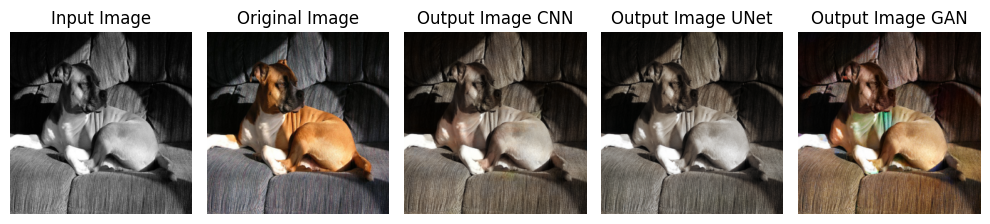

In [27]:
import matplotlib.pyplot as plt
L, AB = val_dataset[420]
AB_pred = net_G(L.unsqueeze(0).to("cuda"))
image_pred = reconstruct_color_image(L, AB_pred.squeeze(0).cpu().detach())
AB_pred_CNN = CNNmodel(L.unsqueeze(0).to("cuda"))

image_pred_CNN = reconstruct_color_image(L, AB_pred_CNN.squeeze(0).cpu().detach())

AB_pred_GAN = GANmodel.net_G(L.unsqueeze(0).to("cuda"))
image_pred_GAN = reconstruct_color_image(L, AB_pred_GAN.squeeze(0).cpu().detach())
image_orig = reconstruct_color_image(L, AB.squeeze(0).cpu().detach())

plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(L.squeeze(0).cpu().detach(), cmap='gray')
plt.title("Input Image")
plt.axis('off')  # Turn off axis labels

# Plot the image
plt.subplot(1, 5, 2)  # 1 row, 2 columns, 1st subplot
plt.imshow(image_orig)
plt.title("Original Image")
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 5, 3)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image_pred_CNN)  # Specify colormap for grayscale
plt.title("Output Image CNN")
plt.axis('off')  # Turn off axis labels

# Plot the second image
plt.subplot(1, 5, 4)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image_pred)  # Specify colormap for grayscale
plt.title("Output Image UNet")
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 5, 5)  # 1 row, 2 columns, 2nd subplot
plt.imshow(image_pred_GAN)  # Specify colormap for grayscale
plt.title("Output Image GAN")
plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between plots
plt.show()

In [24]:
def calculate_mae(y_pred, y):
    # Compute absolute difference
    absolute_diff = torch.abs(y_pred - y)

    # Calculate sum over all dimensions
    mae = torch.sum(torch.mean(absolute_diff, dim=(1,2,3)))
    return mae

In [25]:
from tqdm import tqdm

def getMAELoss(model):
  count = 0
  sum_mae = 0
  device = "cuda"
  for L, AB in tqdm(val_dataloader):
      model = model.to(device)
      AB_pred = model(L.to(device))
      AB_pred = AB_pred.detach().cpu()
      sum_mae+=calculate_mae(AB_pred, AB)
      count+=L.shape[0]
      torch.cuda.empty_cache()

  return sum_mae.item()/count

In [ ]:
models = [CNNmodel.eval(), net_G.eval(), GANmodel.net_G.eval()]
for model in models:
  loss = getMAELoss(model)
  print(loss)

100%|██████████| 63/63 [00:14<00:00,  4.29it/s]


0.08478401947021484


100%|██████████| 63/63 [00:16<00:00,  3.86it/s]


0.08458656311035156


100%|██████████| 63/63 [00:15<00:00,  4.01it/s]

0.08066161346435546


In [ ]:
def reconstruct_color_image_batch(L, AB):
    L = (L + 1.) * 50.
    AB = AB * 110.
    Lab = torch.cat([L, AB], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2)

In [ ]:
!pip install lpips
import lpips

In [ ]:
from tqdm import tqdm

def getlpipsScore(model): #Function to get LPIPS score
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  lpips_model = lpips.LPIPS(net='vgg') #We use VGG features
  model = model.to(device)
  score = 0
  count = 0
  for L, AB in tqdm(val_dataloader):
    AB_pred = model(L.to(device))
    AB_pred = AB_pred.detach().cpu()
    orig_imgs = reconstruct_color_image_batch(L, AB)
    pred_imgs = reconstruct_color_image_batch(L, AB_pred)
    score += torch.sum(lpips_model(orig_imgs, pred_imgs))
    count += L.shape[0]
    torch.cuda.empty_cache()

  return score.item()/count

In [ ]:
getlpipsScore(CNNmodel.eval())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mod

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 63/63 [06:40<00:00,  6.36s/it]


0.14790974426269532

In [ ]:
getlpipsScore(net_G.eval())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mod

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/63 [00:00<?, ?it/s]<ipython-input-18-383fa800de4a>:7: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
  2%|▏         | 1/63 [00:07<08:10,  7.92s/it]<ipython-input-18-383fa800de4a>:7: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-18-383fa800de4a>:7: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
  5%|▍         | 3/63 [00:19<06:14,  6.24s/it]<ipython-input-18-383fa800de4a>:7: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
 10%|▉         | 6/63 [00:35<05:22,  5.66s/it]<ipython-input-18-383fa800de4a>:7: UserWarning: Conversion from CIE-

0.1407251434326172

In [ ]:
getlpipsScore(GANmodel.net_G.eval())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mod

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 63/63 [06:27<00:00,  6.15s/it]


0.13230279541015624